In [208]:
# pip install xgboost

import pandas as pd
import xgboost as xg

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

In [211]:
df = pd.read_csv('../Data/merged_data.csv').iloc[:,1:]

In [212]:
df.head()

,date,daily_rainfall_total,highest_30_min_rainfall,highest_60_min_rainfall,highest_120_min_rainfall,mean_temperature,maximum_temperature,minimum_temperature,mean_wind_speed,max_wind_speed,...,minimum_temperature_14,mean_wind_speed_14,max_wind_speed_14,aedes,dengue,fever,headache,nosebleed,vomit,recent_cases
0,2017-01-01,3.0,2.6,2.6,2.6,26.8,30.0,24.7,11.2,40.7,...,NaN,NaN,NaN,10.0,27.0,69.0,70.0,0.0,100.0,NaN
1,2017-01-02,47.2,32.6,42.2,45.2,26.1,30.5,24.1,6.1,32.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-01-03,0.6,0.6,0.6,0.6,26.3,30.6,24.5,7.6,27.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017-01-04,2.6,2.4,2.4,2.4,26.6,30.2,23.5,9.0,33.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017-01-05,1.2,0.8,1.0,1.2,27.7,31.4,24.4,8.6,33.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [213]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130926 entries, 0 to 130925
Data columns (total 28 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   date                         130926 non-null  object 
 1   daily_rainfall_total         130926 non-null  float64
 2   highest_30_min_rainfall      130926 non-null  float64
 3   highest_60_min_rainfall      130926 non-null  float64
 4   highest_120_min_rainfall     130926 non-null  float64
 5   mean_temperature             130926 non-null  float64
 6   maximum_temperature          130926 non-null  float64
 7   minimum_temperature          130926 non-null  float64
 8   mean_wind_speed              130926 non-null  float64
 9   max_wind_speed               130926 non-null  float64
 10  year                         130926 non-null  int64  
 11  region                       130926 non-null  object 
 12  daily_rainfall_total_14      130107 non-null  float64
 13 

Assumption: Recent cases = 0 for blanks as our source data only collects info on clusters and does not inform us when an area is not a cluster. Data collection stopped after 8 Nov 2020.

In [222]:
df_fillna = df.fillna(0)

We will be looking at weekly data instead of daily data. Thus, remove all na (since the google trends data is weekly)

In [223]:
df2 = df_fillna.dropna()

In [224]:
df2['month'] = df2['date'].str[5:7]
df2['month'] = df2['month'].astype(int)

In [225]:
df3 = df2[df2['date']<='2020-11-08']

In [226]:
df3.drop('date',axis=1,inplace=True)

C:\Users\jinmi\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [227]:
df4 = pd.get_dummies(df3, columns=['region'], drop_first=True)
df4.head()

,daily_rainfall_total,highest_30_min_rainfall,highest_60_min_rainfall,highest_120_min_rainfall,mean_temperature,maximum_temperature,minimum_temperature,mean_wind_speed,max_wind_speed,year,...,region_Tengah,region_Toa Payoh,region_Tuas,region_Tuas South,region_Tuas West,region_Ulu Pandan,region_Upper Peirce Reservoir,region_Upper Thomson,region_Whampoa,region_Yishun
0,3.0,2.6,2.6,2.6,26.8,30.0,24.7,11.2,40.7,2017,...,0,0,0,0,0,0,0,0,0,0
1,47.2,32.6,42.2,45.2,26.1,30.5,24.1,6.1,32.0,2017,...,0,0,0,0,0,0,0,0,0,0
2,0.6,0.6,0.6,0.6,26.3,30.6,24.5,7.6,27.4,2017,...,0,0,0,0,0,0,0,0,0,0
3,2.6,2.4,2.4,2.4,26.6,30.2,23.5,9.0,33.5,2017,...,0,0,0,0,0,0,0,0,0,0
4,1.2,0.8,1.0,1.2,27.7,31.4,24.4,8.6,33.5,2017,...,0,0,0,0,0,0,0,0,0,0


In [228]:
df4.shape

(93877, 89)

In [229]:
df4.corr()['recent_cases'].sort_values(ascending=False).head(25)

recent_cases                      1.000000
dengue                            0.238727
nosebleed                         0.197078
headache                          0.180320
aedes                             0.176548
vomit                             0.174263
fever                             0.159474
region_Chai Chee                  0.075379
region_Ang Mo Kio                 0.050553
year                              0.046982
region_Tai Seng                   0.041299
region_Serangoon                  0.039062
region_Buangkok                   0.031654
region_Bukit Panjang              0.028413
region_Toa Payoh                  0.022681
region_Jurong (West)              0.019366
region_Simei                      0.012634
mean_wind_speed_14                0.012611
mean_wind_speed                   0.011729
region_Marine Parade              0.009816
mean_temperature_14               0.009241
mean_temperature                  0.009091
region_Choa Chu Kang (Central)    0.008823
region_Yish

Correlation between the predictors and target values are quite low. We might not be able to get a model that 

### Random Forest Model

In [168]:
X = df4.drop(['recent_cases'], axis=1)
y = df4['recent_cases']

In [169]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [170]:
rf = RandomForestRegressor()

In [176]:
rf_params = {
    'n_estimators': range(100,500,100),
    'max_depth': [5,7,10,20],
    'max_features': [20,30,35],
    'ccp_alpha': [0.001,0.01,0.05,0.1]
}
gs = GridSearchCV(rf, param_grid=rf_params, cv=3)
gs.fit(X_train, y_train)
print(gs.best_score_)
gs.best_params_

0.38125292463151933


{'ccp_alpha': 0.001, 'max_depth': 20, 'max_features': 30, 'n_estimators': 100}

In [177]:
r2_train = gs.score(X_train, y_train)
r2_test = gs.score(X_test, y_test)
rmse_train = mean_squared_error(y_train, gs.predict(X_train), squared = False)
rmse_test = mean_squared_error(y_test, gs.predict(X_test), squared = False)

print(f'R2 score on train set: {round(r2_train,5)}')
print(f'R2 score on test set: {round(r2_test,5)}')
print(f'RMSE score on train set: {round(rmse_train,5)}')
print(f'RMSE score on test set: {round(rmse_test,5)}')

R2 score on train set: 0.93482
R2 score on test set: 0.49241
RMSE score on train set: 7.72058
RMSE score on test set: 16.30511


Try tuning hyperparements to see if it helps with model improvement

In [195]:
rf_params = {
    'n_estimators': range(100,500,100),
    'max_depth': [10,20,50,100],
    'max_features': [10,20,30,35],
    'ccp_alpha': [0.001,0.005,0.01,0.05,0.1]
}
gs2 = GridSearchCV(rf, param_grid=rf_params, cv=3)
gs2.fit(X_train, y_train)
print(gs2.best_score_)
gs2.best_params_

0.38490384122900867


{'ccp_alpha': 0.01, 'max_depth': 20, 'max_features': 30, 'n_estimators': 100}

In [196]:
r2_train_2 = gs2.score(X_train, y_train)
r2_test_2 = gs2.score(X_test, y_test)
rmse_train_2 = mean_squared_error(y_train, gs2.predict(X_train), squared = False)
rmse_test_2 = mean_squared_error(y_test, gs2.predict(X_test), squared = False)

print(f'R2 score on train set: {round(r2_train_2,5)}')
print(f'R2 score on test set: {round(r2_test_2,5)}')
print(f'RMSE score on train set: {round(rmse_train_2,5)}')
print(f'RMSE score on test set: {round(rmse_test_2,5)}')

R2 score on train set: 0.9311
R2 score on test set: 0.5173
RMSE score on train set: 7.93769
RMSE score on test set: 15.9003


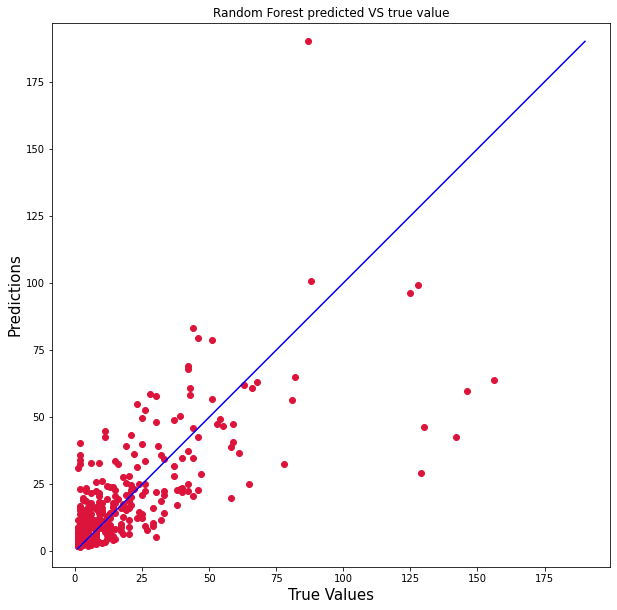

In [209]:
plt.figure(figsize=(10,10))
plt.scatter(y_test, gs2.predict(X_test), c='crimson')

p1 = max(max(gs2.predict(X_test)), max(y_test))
p2 = min(min(gs2.predict(X_test)), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.title('Random Forest predicted VS true value')
plt.show()

Model improved very slightly, there is lesser overfitting now but the model is quite overfitting in general. The above is modelling by imputing NA = 0. We will try to see if the original dataset can provide a better model performance. 

In [232]:
df_new = df.copy() 
df_new.dropna(inplace=True)
df_new['month'] = df_new['date'].str[5:7]
df_new['month'] = df_new['month'].astype(int)
df_new.drop('date',axis=1,inplace=True)
df_new = pd.get_dummies(df_new, columns=['region'], drop_first=True)
df_new.head()

,daily_rainfall_total,highest_30_min_rainfall,highest_60_min_rainfall,highest_120_min_rainfall,mean_temperature,maximum_temperature,minimum_temperature,mean_wind_speed,max_wind_speed,year,...,region_Serangoon North,region_Simei,region_Somerset (Road),region_Tai Seng,region_Tengah,region_Toa Payoh,region_Tuas,region_Ulu Pandan,region_Whampoa,region_Yishun
28,0.0,0.0,0.0,0.0,26.3,28.3,24.5,10.4,30.6,2017,...,0,0,0,0,0,0,0,0,0,0
35,0.0,0.0,0.0,0.0,27.3,32.6,24.9,9.7,27.4,2017,...,0,0,0,0,0,0,0,0,0,0
91,0.0,0.0,0.0,0.0,27.4,31.6,25.0,8.3,32.0,2017,...,0,0,0,0,0,0,0,0,0,0
98,0.0,0.0,0.0,0.0,27.6,34.5,24.9,5.8,26.3,2017,...,0,0,0,0,0,0,0,0,0,0
105,0.2,0.2,0.2,0.2,28.1,34.5,25.3,6.1,28.8,2017,...,0,0,0,0,0,0,0,0,0,0


In [233]:
df_new.shape

(2027, 65)

In [234]:
X_new = df_new.drop(['recent_cases'], axis=1)
y_new = df_new['recent_cases']

X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y_new, test_size=0.2, random_state=42)

In [235]:
rf_params = {
    'n_estimators': range(100,500,100),
    'max_depth': [10,20,50,100],
    'max_features': [10,20,30,35],
    'ccp_alpha': [0.001,0.005,0.01,0.05,0.1]
}
gs_new = GridSearchCV(rf, param_grid=rf_params, cv=3)
gs_new.fit(X_train_new, y_train_new)
print(gs_new.best_score_)
gs_new.best_params_

0.38624752618570124


{'ccp_alpha': 0.01, 'max_depth': 50, 'max_features': 35, 'n_estimators': 100}

In [236]:
r2_train_new = gs_new.score(X_train_new, y_train_new)
r2_test_new = gs_new.score(X_test_new, y_test_new)
rmse_train_new = mean_squared_error(y_train_new, gs_new.predict(X_train_new), squared = False)
rmse_test_new = mean_squared_error(y_test_new, gs_new.predict(X_test_new), squared = False)

print(f'R2 score on train set: {round(r2_train_new,5)}')
print(f'R2 score on test set: {round(r2_test_new,5)}')
print(f'RMSE score on train set: {round(rmse_train_new,5)}')
print(f'RMSE score on test set: {round(rmse_test_new,5)}')

R2 score on train set: 0.93496
R2 score on test set: 0.52273
RMSE score on train set: 7.7121
RMSE score on test set: 15.81064


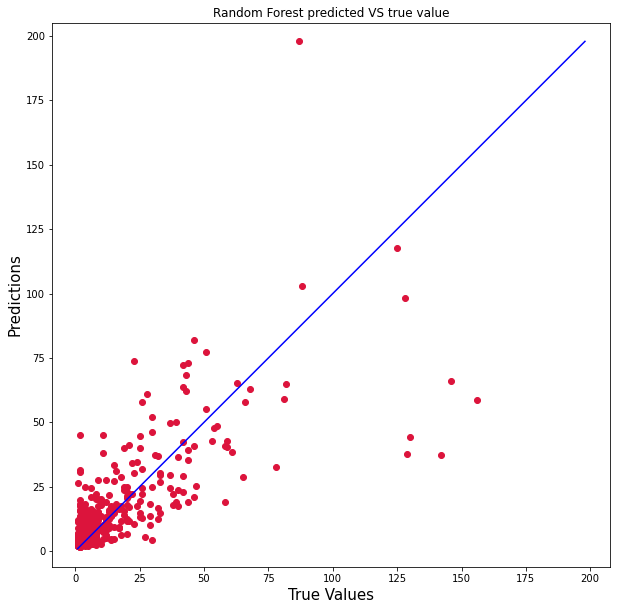

In [237]:
plt.figure(figsize=(10,10))
plt.scatter(y_test_new, gs_new.predict(X_test_new), c='crimson')

p1 = max(max(gs_new.predict(X_test_new)), max(y_test_new))
p2 = min(min(gs_new.predict(X_test_new)), min(y_test_new))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.title('Random Forest predicted VS true value')
plt.show()

Model performance looks to be similar and adding imputing NA = 0 does not affect model performance much. We will try XGBoost to see if we can get a better model.

### XGBoost Model

In [197]:
xgb = xg.XGBRegressor()

In [198]:
xgb_params = {
    'subsample' : [0.3, 0.5, 0.7, 0.9, 1],
    'learning_rate' : [0.001, 0.01, 0.1, 0.3],
    'n_estimators' : range(100,500,100),
    'reg_lambda' : [50, 100, 1000, 10000],
    'reg_alpha' : [0, 1, 10, 100, 1000]
}
gs3 = GridSearchCV(xgb, param_grid=xgb_params, cv=3)
gs3.fit(X_train, y_train)
print(gs3.best_score_)
gs3.best_params_

0.3770442492197836


{'learning_rate': 0.3,
 'n_estimators': 400,
 'reg_alpha': 1,
 'reg_lambda': 1000,
 'subsample': 1}

In [199]:
r2_train_3 = gs3.score(X_train, y_train)
r2_test_3 = gs3.score(X_test, y_test)
rmse_train_3 = mean_squared_error(y_train, gs3.predict(X_train), squared = False)
rmse_test_3 = mean_squared_error(y_test, gs3.predict(X_test), squared = False)

print(f'R2 score on train set: {round(r2_train_3,5)}')
print(f'R2 score on test set: {round(r2_test_3,5)}')
print(f'RMSE score on train set: {round(rmse_train_3,5)}')
print(f'RMSE score on test set: {round(rmse_test_3,5)}')

R2 score on train set: 0.75825
R2 score on test set: 0.55865
RMSE score on train set: 14.86842
RMSE score on test set: 15.20412


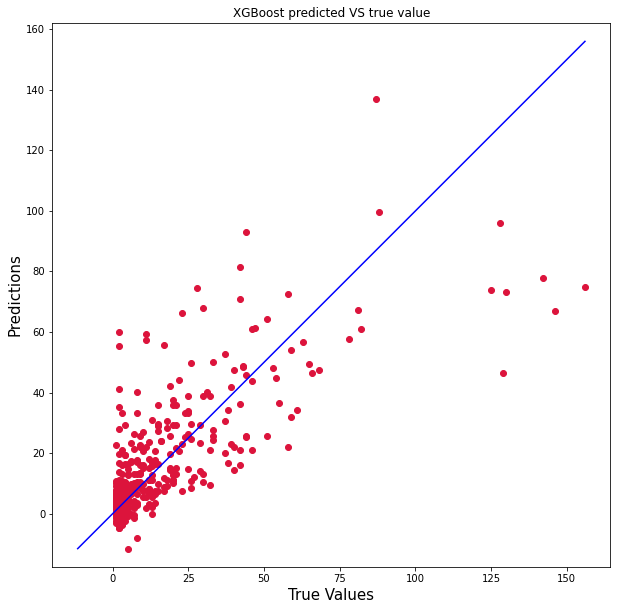

In [210]:
plt.figure(figsize=(10,10))
plt.scatter(y_test, gs3.predict(X_test), c='crimson')

p1 = max(max(gs3.predict(X_test)), max(y_test))
p2 = min(min(gs3.predict(X_test)), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.title('XGBoost predicted VS true value')
plt.show()

Not fantastic, but lesser overfitting. Comparing all the models, the XGBoost is the best performing model.

In [204]:
test = pd.DataFrame({'feature':X.columns,'coefficient':gs3.best_estimator_.feature_importances_})

In [206]:
test.sort_values(by = 'coefficient', ascending = False).head(10)

,feature,coefficient
49,region_Tengah,0.103890
39,region_Paya Lebar,0.072038
23,region_Chai Chee,0.044318
17,region_Ang Mo Kio,0.037927
48,region_Tai Seng,0.037785
44,region_Serangoon,0.033234
42,region_Seletar,0.032758
18,region_Botanic Garden,0.029379
24,region_Changi,0.029242
27,region_Dhoby Ghaut,0.026228


Top 10 most important features to the model are the region features.